# Babagsak ba ako? Model Interpretability using Borderline SMOTE and SHAP

# Objective

Schools have access to large amounts of data on their students, and the potential of this may not be fully harnessed yet. Too often, the picture of student performance is limited and the explanation given to student failures is even more limited. The goal of this project is to use student features that are quite easily accessible by schools to predict whether students will pass or fail a certain subject, and to use interpretability methods to give explanations on what features most strongly influenced a prediction of pass or fail.

# Highlights
1. Resampling methods decreased bias in predictions. Without it, results were biased to majority class.
2. Utilizing resampling, best performing models were AdaBoost (F1: 80.99%) and XGBoost (F1: 80.67%).
3. Using SHAP, Fjob_other pushes model prediction towards `fail` while `activites_yes` pushes towards `pass`.

# Extensions to previous project:

1. Changed scoring metric to F1
    - Balance between precision (minimizes false positives) and recall (minimizes false negatives)
2. Added XGBoostClassifier model
    - More regularized GBM,  improves generalization using L1 and L2 regularization
3. Used Borderline SMOTE for resampling
    - Variant of SMOTE, uses borderline samples in the data
4. Used SHAP (Shapley Additive Explanations) for interpretability
    - Explains how each feature influences the prediction of the model

# Dataset Description
The dataset used was the “Student performance dataset” from UCI Machine learning repository, collected via questionnaires and school reports in 2014. It contained data on the students math grades (our target variable). Its features ranged from demographics or home conditions, school-related features and social features.

# Feature description
Reference: https://archive.ics.uci.edu/ml/datasets/student+performance#

1. school - student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira)
2. sex - student's sex (binary: 'F' - female or 'M' - male)
3. age - student's age (numeric: from 15 to 22)
4. address - student's home address type (binary: 'U' - urban or 'R' - rural)
5. famsize - family size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3)
6. Pstatus - parent's cohabitation status (binary: 'T' - living together or 'A' - apart)
7. Medu - mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 â€“ 5th to 9th grade, 3 â€“ secondary education or 4 â€“ higher education)
8. Fedu - father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 â€“ 5th to 9th grade, 3 â€“ secondary education or 4 â€“ higher education)
9. Mjob - mother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
10. Fjob - father's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
11. reason - reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other')
12. guardian - student's guardian (nominal: 'mother', 'father' or 'other')
13. traveltime - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)
14. studytime - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
15. failures - number of past class failures (numeric: n if 1<=n<3, else 4)
16. schoolsup - extra educational support (binary: yes or no)
17. famsup - family educational support (binary: yes or no)
18. paid - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)
19. activities - extra-curricular activities (binary: yes or no)
20. nursery - attended nursery school (binary: yes or no)
21. higher - wants to take higher education (binary: yes or no)
22. internet - Internet access at home (binary: yes or no)
23. romantic - with a romantic relationship (binary: yes or no)
24. famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)
25. freetime - free time after school (numeric: from 1 - very low to 5 - very high)
26. goout - going out with friends (numeric: from 1 - very low to 5 - very high)
27. Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)
28. Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
29. health - current health status (numeric: from 1 - very bad to 5 - very good)
30. absences - number of school absences (numeric: from 0 to 93)

These will be removed from dataset to gain insight on best predictions without previous grades:

31. G1 - first period grade (numeric: from 0 to 20)
32. G2 - second period grade (numeric: from 0 to 20)
33. G3 - final grade (numeric: from 0 to 20, output target)

# Loading the dataset and Preprocessing

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import warnings
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from imblearn.over_sampling import BorderlineSMOTE
import shap


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [8]:
# load the dataset
df_orig = pd.read_csv('student-mat.csv', sep=';')
df = df_orig
print(df.shape)
df.head()

(395, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10


In [9]:
# assume passing grade is 70%
df['fail'] = np.where(df['G3']< 14, 1, 0)
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,fail
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6,1
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6,1
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10,1
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15,0
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10,1


In [10]:
# remove G1, G2, G3
df = df.drop(columns=['G1', 'G2', 'G3'])
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,fail
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,1
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,1
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,1
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,0
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,1


# Exploratory Data Analysis

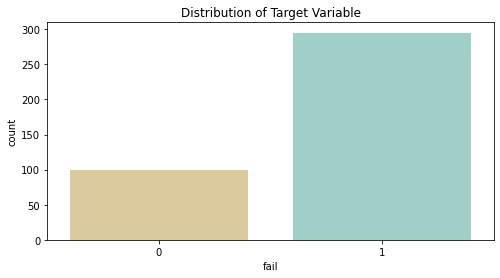

In [31]:
# distribution of target variable
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.countplot(df['fail'],label="Count", palette='BrBG', ax=ax)
ax.set_title('Distribution of Target Variable');

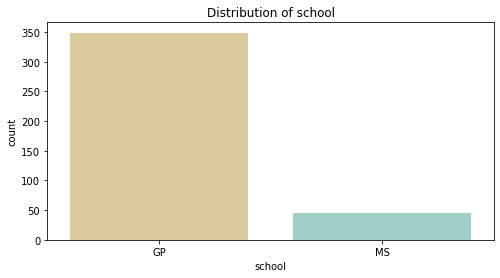

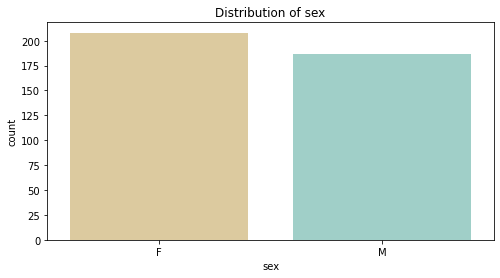

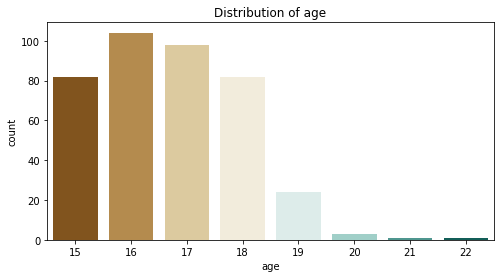

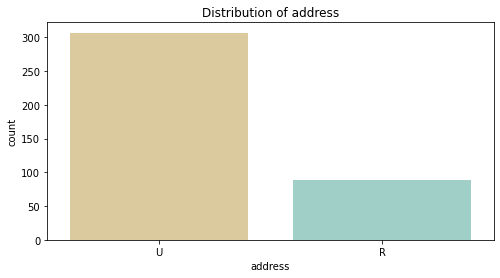

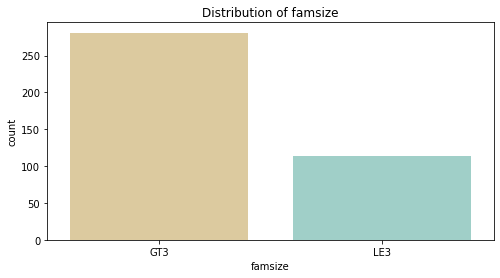

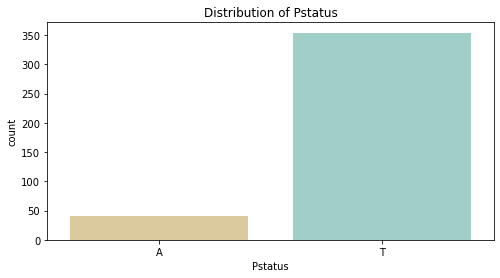

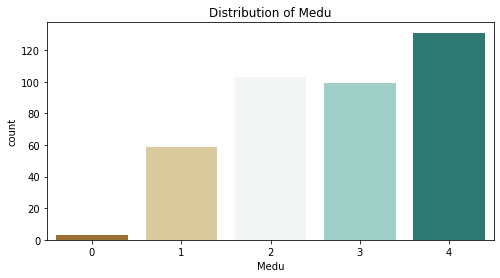

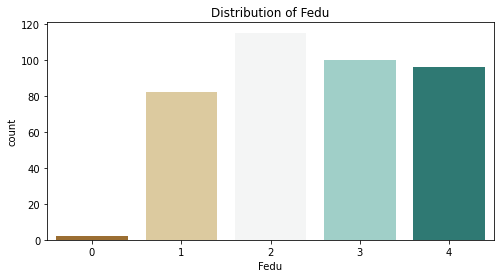

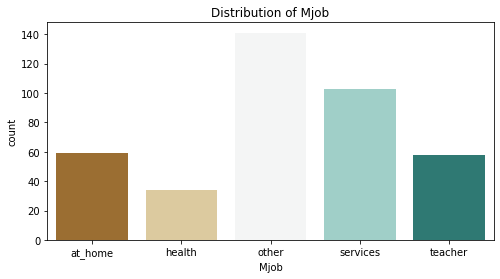

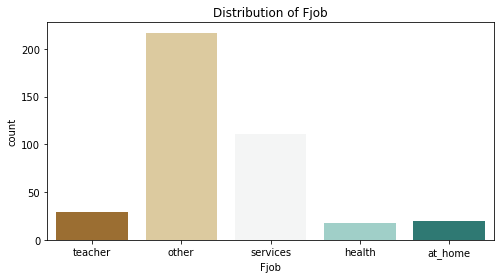

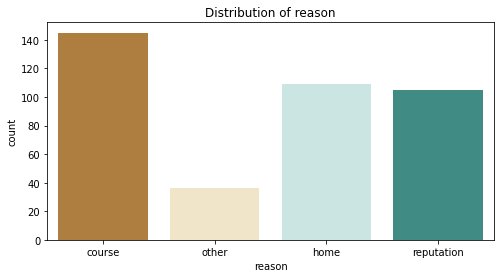

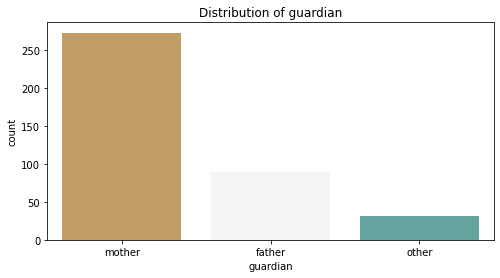

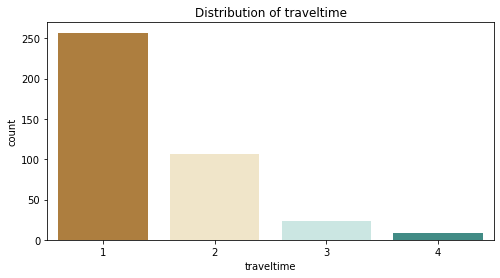

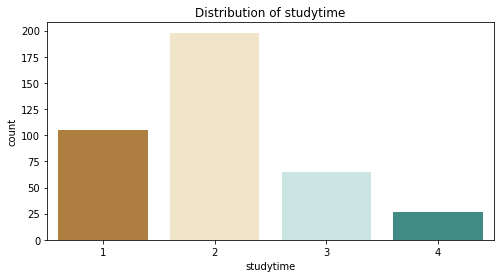

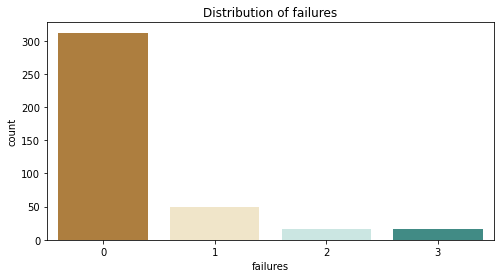

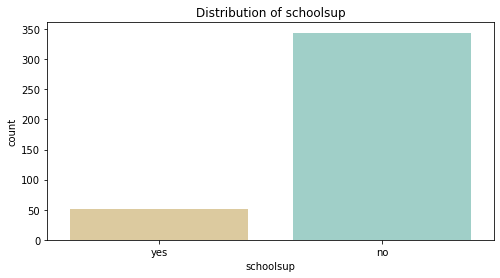

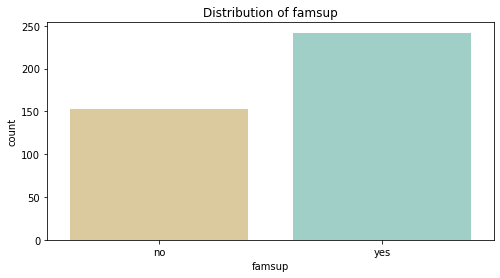

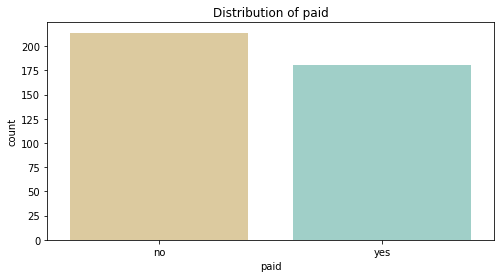

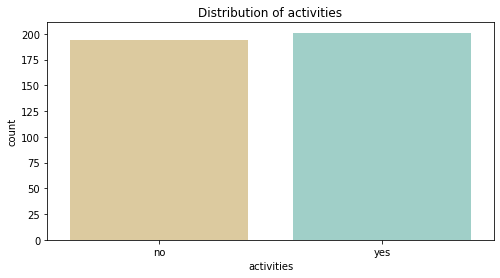

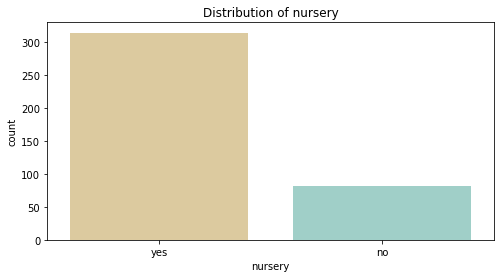

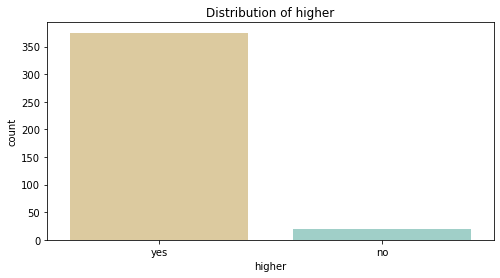

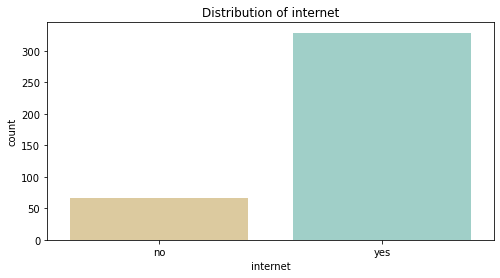

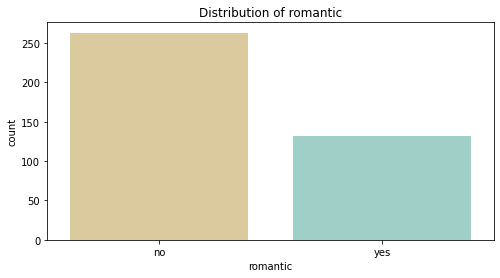

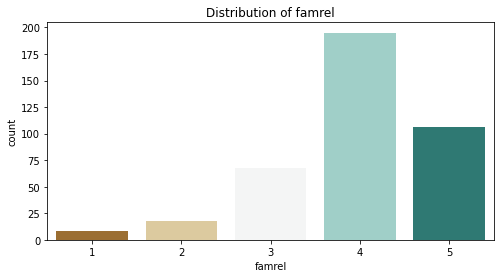

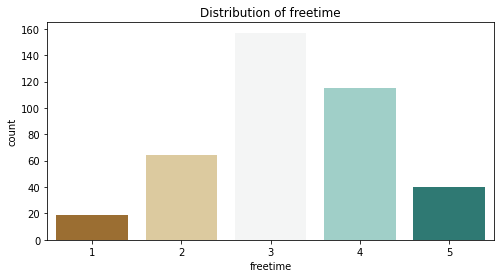

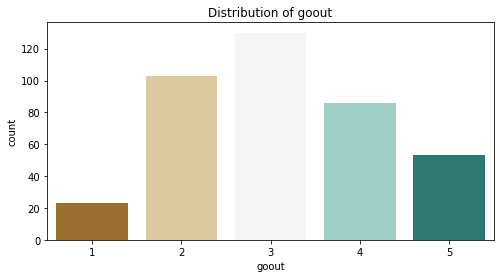

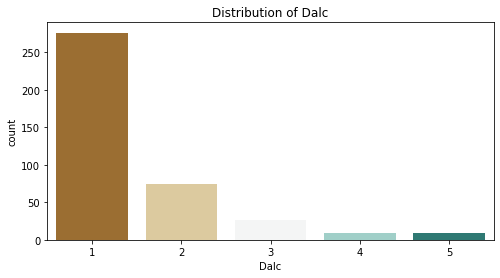

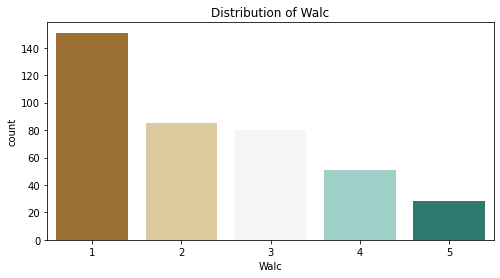

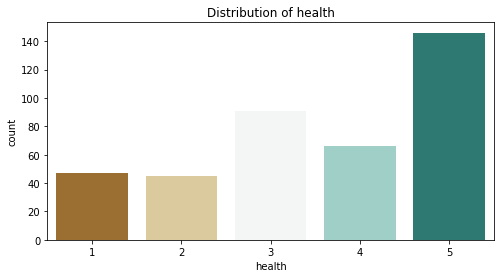

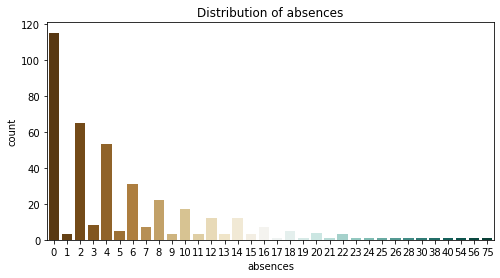

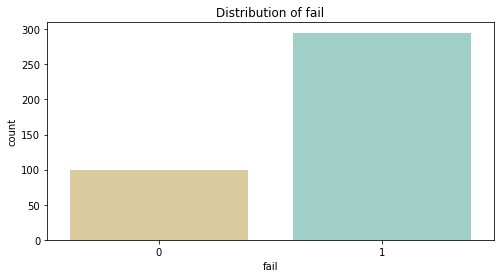

In [32]:
# distribution of each feature
for col in df.columns:
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    sns.countplot(df[col],label="Count", palette='BrBG', ax=ax)
    ax.set_title(f'Distribution of {col}');
    plt.show()

In [15]:
# compute proportion chance criterion
pcc = ((df[df['fail']==1].shape[0]/df.shape[0])**2 
       + (df[df['fail']==0].shape[0]/df.shape[0])**2)

print("Proportion Chance Criterion = {}%".format(100*pcc))
print("1.25*Proportion Chance Criterion = {}%".format(1.25*100*pcc))

Proportion Chance Criterion = 62.18554718795064%
1.25*Proportion Chance Criterion = 77.7319339849383%


In [16]:
# check missing values
df.isnull().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
fail          0
dtype: int64

# Methodology

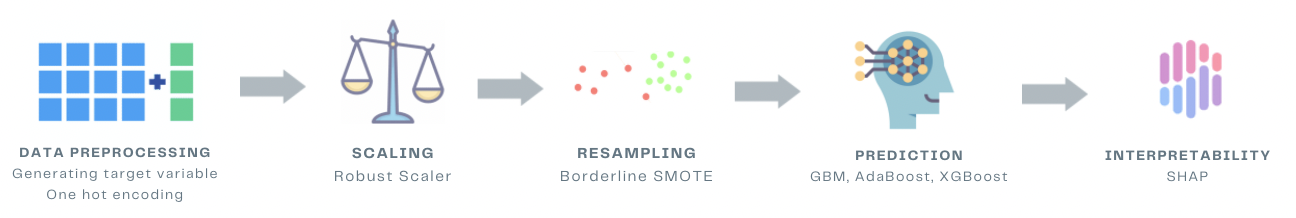

1. The data was preprocessed to create a new column `fail` which identifies whether a given student passed the subject (`0`) or failed the subject (`1`). The passing grade was considered to be 70%. The categorical features were then One Hot Encoded. 

2. Predictions were made without resampling techniques, and the following models were used: Gradient Boosting Method, AdaBoost and XGBoost. F1 score was used as a metric to give a balance between precision and recall. It is important to decrease false negatives because it is not desirable to tag a student as "passing" when they are actually failing. It is also important to decrease false positives in order to properly manage resources, we do not want students who are actually "passing" to be tagged as "failing". Confusion matrices were generated to inspect the number of predictions for the positive and negative class and determine whether the model was biased. 

3. After this, the data was resampled using Borderline SMOTE and predictions were made using the 3 models. Hyperparameter tuning was done to find the best parameters for both the resampler and the model used. Confusion matrices were also generated.

4. SHAP was used to interpret the predictions and explain how each feature influences the prediction of the model

## One Hot Encode categorical values

In [17]:
# remove target variable
X_ohe = df.drop('fail', axis=1)

# one hot encode
X_ohe = pd.get_dummies(X_ohe)
print(X_ohe.shape)
X_ohe.head()

(395, 56)


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_no,schoolsup_yes,famsup_no,famsup_yes,paid_no,paid_yes,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,1,3,6,1,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,1,0,1,0
1,17,1,1,1,2,0,5,3,3,1,1,3,4,1,0,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,1,0
2,15,1,1,1,2,3,4,3,2,2,3,3,10,1,0,1,0,0,1,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0
3,15,4,2,1,3,0,3,2,2,1,1,5,2,1,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1
4,16,3,3,1,2,0,4,3,2,1,2,5,4,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,1,0,0,1,0,1,1,0,1,0


## Make Predictions without using Resampling Methods

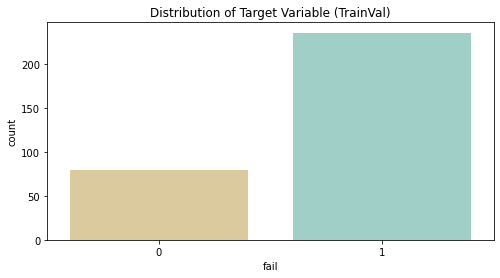

In [33]:
# get features and target
X = X_ohe
y = df['fail']

# split dataset
(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y, 
                                           random_state=0, test_size=0.2, 
                                           stratify=y)

# visualize stratified counts
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.countplot(y_trainval,label="Count", palette='BrBG', ax=ax)
ax.set_title('Distribution of Target Variable (TrainVal)')
plt.show()

### Gradient Boosting Method

In [19]:
%%time

# use pipeline to scale the data, perform hyperparameter tuning
scaler = ('scaler', RobustScaler())
classifier = ('GBM', GradientBoostingClassifier(random_state=0))
scoring=['f1']
cv = StratifiedKFold()
params = {'GBM__n_estimators': [10, 50, 100, 500]}

start_time = time.time()
pipe = Pipeline([scaler, classifier])
grid_search = GridSearchCV(pipe, refit='f1', param_grid=params,
                           scoring=scoring, cv=cv, return_train_score=True)
grid_search.fit(X_trainval, y_trainval)
          
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = (results_df[['param_GBM__n_estimators',
                          'mean_train_f1', 'mean_test_f1',
                          'rank_test_f1']])
results_df = results_df.sort_values(by=['rank_test_f1']).reset_index(
    drop=True)
results_df.columns = ['GBM parameter: n_estimators', 'Train F1 Score',
                      'Val F1 Score', 'Ranking']
run_time = time.time() - start_time
display(results_df)

,GBM parameter: n_estimators,Train F1 Score,Val F1 Score,Ranking
0,50,0.966406,0.847699,1
1,10,0.880870,0.842712,2
2,100,0.992079,0.841957,3
3,500,1.000000,0.828636,4


CPU times: user 5.14 s, sys: 11.6 ms, total: 5.15 s
Wall time: 5.15 s


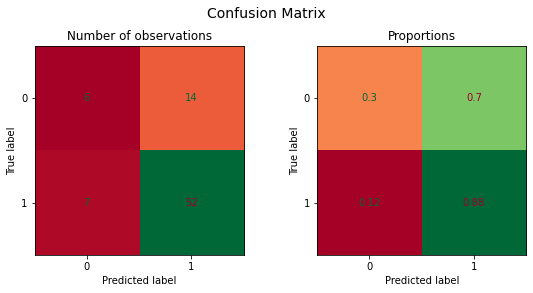

F1 Score: 0.8320


In [20]:
# make predictions using model with optimal hyperparameters
robust_scaler = RobustScaler().fit(X_trainval)
X_trainval_transformed = robust_scaler.transform(X_trainval)
X_holdout_transformed = robust_scaler.transform(X_holdout)

best_model = GradientBoostingClassifier(random_state=0, n_estimators=50)
best_model.fit(X_trainval_transformed, y_trainval)
y_pred = best_model.predict(X_holdout_transformed)

# generate confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ConfusionMatrixDisplay.from_predictions(y_holdout, y_pred, ax=ax[0],
                                        cmap='RdYlGn', colorbar=False)
ax[0].set_title('Number of observations')
ConfusionMatrixDisplay.from_predictions(y_holdout, y_pred, ax=ax[1],
                                        cmap='RdYlGn', colorbar=False,
                                        normalize='true')
ax[1].set_title('Proportions')
fig.suptitle('Confusion Matrix', fontsize=14)
fig.tight_layout()
plt.show()
print(f'F1 Score: {f1_score(y_holdout, y_pred):.4f}')

### AdaBoost

In [21]:
%%time

# use pipeline to scale the data, perform hyperparameter tuning
scaler = ('scaler', RobustScaler())
classifier = ('AdaBoost', AdaBoostClassifier(random_state=0))
scoring=['f1']
cv = StratifiedKFold()
params = {'AdaBoost__n_estimators': [10, 50, 100, 500]}

start_time = time.time()
pipe = Pipeline([scaler, classifier])
grid_search = GridSearchCV(pipe, refit='f1', param_grid=params,
                           scoring=scoring, cv=cv, return_train_score=True)
grid_search.fit(X_trainval, y_trainval)
          
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = (results_df[['param_AdaBoost__n_estimators',
                          'mean_train_f1', 'mean_test_f1',
                          'rank_test_f1']])
results_df = results_df.sort_values(by=['rank_test_f1']).reset_index(
    drop=True)
results_df.columns = ['AdaBoost parameter: n_estimators', 'Train F1 Score',
                      'Val F1 Score', 'Ranking']
display(results_df)

,AdaBoost parameter: n_estimators,Train F1 Score,Val F1 Score,Ranking
0,10,0.878756,0.852428,1
1,50,0.916152,0.830205,2
2,100,0.927488,0.826803,3
3,500,0.946485,0.808543,4


CPU times: user 8.17 s, sys: 58.9 ms, total: 8.23 s
Wall time: 8.22 s


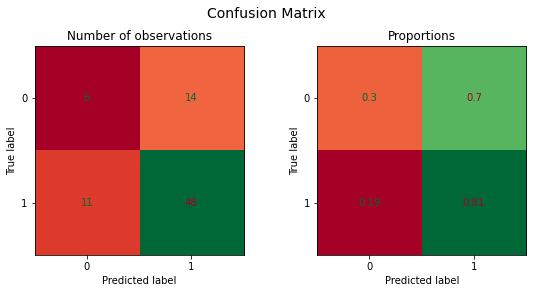

F1 Score: 0.7934


In [22]:
# make predictions using model with optimal hyperparameters
robust_scaler = RobustScaler().fit(X_trainval)
X_trainval_transformed = robust_scaler.transform(X_trainval)
X_holdout_transformed = robust_scaler.transform(X_holdout)

best_model = AdaBoostClassifier(random_state=0, n_estimators=10)
best_model.fit(X_trainval_transformed, y_trainval)
y_pred = best_model.predict(X_holdout_transformed)

# generate confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ConfusionMatrixDisplay.from_predictions(y_holdout, y_pred, ax=ax[0],
                                        cmap='RdYlGn', colorbar=False)
ax[0].set_title('Number of observations')
ConfusionMatrixDisplay.from_predictions(y_holdout, y_pred, ax=ax[1],
                                        cmap='RdYlGn', colorbar=False,
                                        normalize='true')
ax[1].set_title('Proportions')
fig.suptitle('Confusion Matrix', fontsize=14)
fig.tight_layout()
plt.show()
print(f'F1 Score: {f1_score(y_holdout, y_pred):.4f}')

### XGBoost

In [23]:
%%time

# use pipeline to scale the data, perform hyperparameter tuning
scaler = ('scaler', RobustScaler())
classifier = ('XGBoost', XGBClassifier(random_state=0))
scoring=['f1']
cv = StratifiedKFold()
params = {'XGBoost__n_estimators': [10, 50, 100, 500]}

start_time = time.time()
pipe = Pipeline([scaler, classifier])
grid_search = GridSearchCV(pipe, refit='f1', param_grid=params,
                           scoring=scoring, cv=cv, return_train_score=True)
grid_search.fit(X_trainval, y_trainval)
          
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = (results_df[['param_XGBoost__n_estimators',
                          'mean_train_f1', 'mean_test_f1',
                          'rank_test_f1']])
results_df = results_df.sort_values(by=['rank_test_f1']).reset_index(
    drop=True)
results_df.columns = ['XGBoost parameter: n_estimators', 'Train F1 Score',
                      'Val F1 Score', 'Ranking']
display(results_df)

/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:43:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:43:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:43:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:43:24] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:43:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:43:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:43:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:43:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:44:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:44:26] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:44:40] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:45:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:45:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:45:44] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:46:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:46:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:48:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:49:24] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:50:38] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:52:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:53:34] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,XGBoost parameter: n_estimators,Train F1 Score,Val F1 Score,Ranking
0,50,1.000000,0.833500,1
1,10,0.985917,0.832237,2
2,100,1.000000,0.822702,3
3,500,1.000000,0.810584,4


CPU times: user 19min 34s, sys: 1min 37s, total: 21min 11s
Wall time: 10min 38s


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:53:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


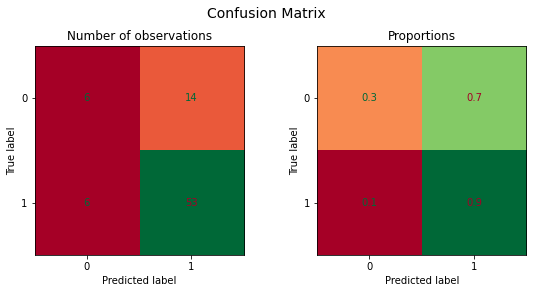

F1 Score: 0.8413


In [24]:
# make predictions using model with optimal hyperparameters
robust_scaler = RobustScaler().fit(X_trainval)
X_trainval_transformed = robust_scaler.transform(X_trainval)
X_holdout_transformed = robust_scaler.transform(X_holdout)

best_model = XGBClassifier(random_state=0, n_estimators=50)
best_model.fit(X_trainval_transformed, y_trainval)
y_pred = best_model.predict(X_holdout_transformed)

# generate confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ConfusionMatrixDisplay.from_predictions(y_holdout, y_pred, ax=ax[0],
                                        cmap='RdYlGn', colorbar=False)
ax[0].set_title('Number of observations')
ConfusionMatrixDisplay.from_predictions(y_holdout, y_pred, ax=ax[1],
                                        cmap='RdYlGn', colorbar=False,
                                        normalize='true')
ax[1].set_title('Proportions')
fig.suptitle('Confusion Matrix', fontsize=14)
fig.tight_layout()
plt.show()
print(f'F1 Score: {f1_score(y_holdout, y_pred):.4f}')

## Predictions with Resampling Method: Borderline SMOTE

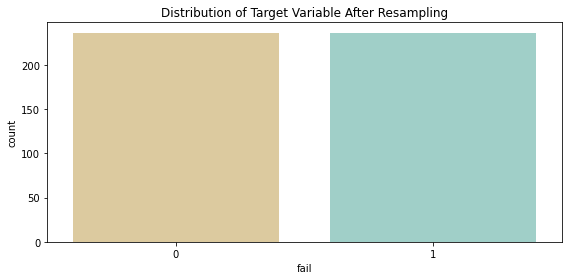

In [34]:
# check distribution after resampling
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
bsmote = BorderlineSMOTE(random_state=0)
X_bsmote, y_bsmote = bsmote.fit_resample(X_trainval, y_trainval)
sns.countplot(x=y_bsmote, ax=ax, palette='BrBG')
ax.set_title('Distribution of Target Variable After Resampling')

fig.tight_layout()
plt.show()

### Gradient Boosting Method

In [35]:
%%time

# use pipeline to scale data, hyperparameter tuning on resampling technique
scaler = ('scaler', RobustScaler())
classifier = ('GBM', GradientBoostingClassifier(random_state=0))
resampler = ('BSMOTE', BorderlineSMOTE(random_state=0))
scoring=['f1']
params = {'BSMOTE__sampling_strategy': [0.6, 0.8, 1],
          'BSMOTE__k_neighbors': [3, 5, 7, 10]}
cv = StratifiedKFold()

start_time = time.time()
pipe = imbpipeline([resampler, scaler, classifier])
grid_search = GridSearchCV(pipe, refit='f1', param_grid=params,
                           scoring=scoring, cv=cv, return_train_score=True)
grid_search.fit(X_trainval, y_trainval)
          
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = (results_df[['param_BSMOTE__k_neighbors',
                          'param_BSMOTE__sampling_strategy',
                          'mean_train_f1', 'mean_test_f1',
                          'rank_test_f1']])
results_df = results_df.sort_values(by=['rank_test_f1']).reset_index(
    drop=True)
results_df.columns = ['BSMOTE k_neighbors', 'BSMOTE sampling_strategy',
                      'Train F1 Score', 'Val F1 Score', 'Ranking']
run_time = time.time() - start_time
display(results_df)

,BSMOTE k_neighbors,BSMOTE sampling_strategy,Train F1 Score,Val F1 Score,Ranking
0,5,0.6,0.994706,0.844053,1
1,3,0.6,0.992059,0.842570,2
2,3,1,0.994695,0.841772,3
3,7,0.8,0.994698,0.839340,4
4,5,1,0.994139,0.837997,5
5,10,0.8,0.996286,0.836909,6
6,10,0.6,0.993628,0.834891,7
7,7,0.6,0.996817,0.832340,8
8,3,0.8,0.992567,0.829511,9
9,5,0.8,0.993628,0.825534,10


CPU times: user 42.5 s, sys: 1.37 s, total: 43.9 s
Wall time: 25.1 s


In [36]:
%%time

# using best hyperparameters for resampling technique
# use pipeline to scale data, hyperparameter tuning on model parameters
scaler = ('scaler', RobustScaler())
classifier = ('GBM', GradientBoostingClassifier(random_state=0))
resampler = ('BSMOTE', BorderlineSMOTE(sampling_strategy=0.6, k_neighbors=5,
                                       random_state=0))
scoring=['f1']
cv = StratifiedKFold()
params = {'GBM__n_estimators': [10, 50, 100, 500]}

start_time = time.time()
pipe = imbpipeline([resampler, scaler, classifier])
grid_search = GridSearchCV(pipe, refit='f1', param_grid=params,
                           scoring=scoring, cv=cv, return_train_score=True)
grid_search.fit(X_trainval, y_trainval)
          
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = (results_df[['param_GBM__n_estimators',
                          'mean_train_f1', 'mean_test_f1',
                          'rank_test_f1']])
results_df = results_df.sort_values(by=['rank_test_f1']).reset_index(
    drop=True)
results_df.columns = ['GBM parameter: n_estimators', 'Train F1 Score',
                      'Val F1 Score', 'Ranking']
run_time = time.time() - start_time
display(results_df)

,GBM parameter: n_estimators,Train F1 Score,Val F1 Score,Ranking
0,100,0.994706,0.844053,1
1,10,0.895709,0.841694,2
2,500,1.000000,0.835224,3
3,50,0.970874,0.830531,4


CPU times: user 16.7 s, sys: 527 ms, total: 17.2 s
Wall time: 10.8 s


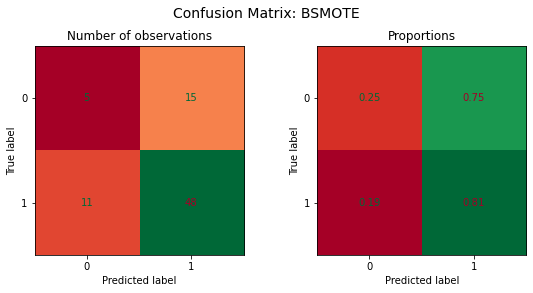

F1 Score (BSMOTE): 0.7869


In [37]:
# make predictions using optimal hyperparameters for resampling technique and model
bsmote = BorderlineSMOTE(sampling_strategy=0.6, k_neighbors=5, random_state=0)
X_bsmote, y_bsmote = bsmote.fit_resample(X_trainval, y_trainval)

robust_scaler = RobustScaler().fit(X_bsmote)
X_bsmote_transformed = robust_scaler.transform(X_bsmote)
X_holdout_transformed = robust_scaler.transform(X_holdout)

best_model = GradientBoostingClassifier(n_estimators=100, random_state=0)
best_model.fit(X_bsmote_transformed, y_bsmote)
y_pred = best_model.predict(X_holdout_transformed)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ConfusionMatrixDisplay.from_predictions(y_holdout, y_pred, ax=ax[0],
                                        cmap='RdYlGn', colorbar=False)
ax[0].set_title('Number of observations')
ConfusionMatrixDisplay.from_predictions(y_holdout, y_pred, ax=ax[1],
                                        cmap='RdYlGn', colorbar=False,
                                        normalize='true')
ax[1].set_title('Proportions')
fig.suptitle('Confusion Matrix: BSMOTE', fontsize=14)
fig.tight_layout()
plt.show()
print(f'F1 Score (BSMOTE): {f1_score(y_holdout, y_pred):.4f}')

### AdaBoost

In [38]:
%%time

# use pipeline to scale data, hyperparameter tuning on resampling technique
scaler = ('scaler', RobustScaler())
classifier = ('AdaBoost', AdaBoostClassifier(random_state=0))
resampler = ('BSMOTE', BorderlineSMOTE(random_state=0))
scoring=['f1']
params = {'BSMOTE__sampling_strategy': [0.6, 0.8, 1],
          'BSMOTE__k_neighbors': [3, 5, 7, 10]}
cv = StratifiedKFold()

start_time = time.time()
pipe = imbpipeline([resampler, scaler, classifier])
grid_search = GridSearchCV(pipe, refit='f1', param_grid=params,
                           scoring=scoring, cv=cv, return_train_score=True)
grid_search.fit(X_trainval, y_trainval)
          
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = (results_df[['param_BSMOTE__k_neighbors',
                          'param_BSMOTE__sampling_strategy',
                          'mean_train_f1', 'mean_test_f1',
                          'rank_test_f1']])
results_df = results_df.sort_values(by=['rank_test_f1']).reset_index(
    drop=True)
results_df.columns = ['BSMOTE k_neighbors', 'BSMOTE sampling_strategy',
                      'Train F1 Score', 'Val F1 Score', 'Ranking']
run_time = time.time() - start_time
display(results_df)

,BSMOTE k_neighbors,BSMOTE sampling_strategy,Train F1 Score,Val F1 Score,Ranking
0,3,0.6,0.908274,0.833476,1
1,7,0.6,0.908615,0.832455,2
2,5,0.6,0.906952,0.830748,3
3,5,0.8,0.908035,0.830420,4
4,10,0.6,0.906540,0.824733,5
5,3,0.8,0.907180,0.820886,6
6,3,1,0.899903,0.816699,7
7,7,0.8,0.903822,0.815492,8
8,10,0.8,0.909522,0.812106,9
9,5,1,0.901170,0.810199,10


CPU times: user 41.7 s, sys: 1.72 s, total: 43.5 s
Wall time: 24.4 s


In [39]:
%%time
# using best hyperparameters for resampling technique
# use pipeline to scale data, hyperparameter tuning on model parameters
scaler = ('scaler', RobustScaler())
classifier = ('AdaBoost', AdaBoostClassifier(random_state=0))
resampler = ('BSMOTE', BorderlineSMOTE(k_neighbors=3, sampling_strategy=0.6, random_state=0))
scoring=['f1']
cv = StratifiedKFold()
params = {'AdaBoost__n_estimators': [10, 50, 100, 500]}

start_time = time.time()
pipe = imbpipeline([resampler, scaler, classifier])
grid_search = GridSearchCV(pipe, refit='f1', param_grid=params, scoring=scoring, cv=cv, return_train_score=True)
grid_search.fit(X_trainval, y_trainval)
          
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = (results_df[['param_AdaBoost__n_estimators',
                          'mean_train_f1', 'mean_test_f1',
                          'rank_test_f1']])
results_df = results_df.sort_values(by=['rank_test_f1']).reset_index(drop=True)
results_df.columns = ['AdaBoost parameter: n_estimators', 'Train F1 Score', 'Val F1 Score', 'Ranking']
run_time = time.time() - start_time
display(results_df)

,AdaBoost parameter: n_estimators,Train F1 Score,Val F1 Score,Ranking
0,50,0.908274,0.833476,1
1,100,0.922115,0.821368,2
2,10,0.867680,0.817728,3
3,500,0.946913,0.810726,4


CPU times: user 19.8 s, sys: 520 ms, total: 20.3 s
Wall time: 13.9 s


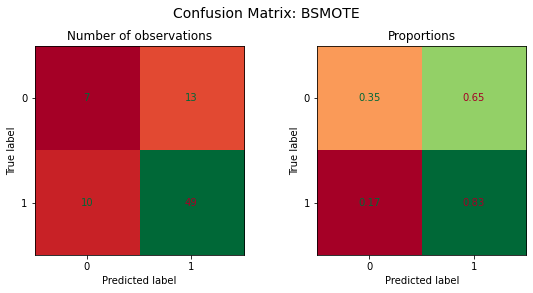

F1 Score (BSMOTE): 0.8099


In [40]:
# make predictions using optimal hyperparameters for resampling technique and model
bsmote = BorderlineSMOTE(sampling_strategy=0.6, k_neighbors=3, random_state=0)
X_bsmote, y_bsmote = bsmote.fit_resample(X_trainval, y_trainval)

robust_scaler = RobustScaler().fit(X_bsmote)
X_bsmote_transformed = robust_scaler.transform(X_bsmote)
X_holdout_transformed = robust_scaler.transform(X_holdout)

best_model = AdaBoostClassifier(n_estimators=50, random_state=0)
best_model.fit(X_bsmote_transformed, y_bsmote)
y_pred = best_model.predict(X_holdout_transformed)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ConfusionMatrixDisplay.from_predictions(y_holdout, y_pred, ax=ax[0],
                                        cmap='RdYlGn', colorbar=False)
ax[0].set_title('Number of observations')
ConfusionMatrixDisplay.from_predictions(y_holdout, y_pred, ax=ax[1],
                                        cmap='RdYlGn', colorbar=False,
                                        normalize='true')
ax[1].set_title('Proportions')
fig.suptitle('Confusion Matrix: BSMOTE', fontsize=14)
fig.tight_layout()
plt.show()
print(f'F1 Score (BSMOTE): {f1_score(y_holdout, y_pred):.4f}')

## XGBoost

In [41]:
%%time

# use pipeline to scale data, hyperparameter tuning on resampling technique
scaler = ('scaler', RobustScaler())
classifier = ('XGBoost', XGBClassifier(random_state=0))
resampler = ('BSMOTE', BorderlineSMOTE(random_state=0))
scoring=['f1']
params = {'BSMOTE__sampling_strategy': [0.6, 0.8, 1],
          'BSMOTE__k_neighbors': [3, 5, 7, 10]}
cv = StratifiedKFold()

start_time = time.time()
pipe = imbpipeline([resampler, scaler, classifier])
grid_search = GridSearchCV(pipe, refit='f1', param_grid=params,
                           scoring=scoring, cv=cv, return_train_score=True)
grid_search.fit(X_trainval, y_trainval)
          
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = (results_df[['param_BSMOTE__k_neighbors',
                          'param_BSMOTE__sampling_strategy',
                          'mean_train_f1', 'mean_test_f1',
                          'rank_test_f1']])
results_df = results_df.sort_values(by=['rank_test_f1']).reset_index(
    drop=True)
results_df.columns = ['BSMOTE k_neighbors', 'BSMOTE sampling_strategy',
                      'Train F1 Score', 'Val F1 Score', 'Ranking']
run_time = time.time() - start_time
display(results_df)

/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:04:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:04:24] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:04:49] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:05:15] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:05:44] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:06:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:06:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:06:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:07:18] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:07:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:08:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:08:41] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:09:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:09:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:10:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:10:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:10:53] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:11:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:11:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:12:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:12:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:12:48] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:13:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:13:44] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:14:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:14:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:15:05] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:15:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:15:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:16:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:16:46] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:17:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:17:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:17:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:18:24] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:18:48] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:19:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:19:38] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:19:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:20:26] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:20:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:21:19] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:21:47] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:22:15] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:22:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:23:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:23:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:24:00] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:24:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:24:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:25:24] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:25:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:26:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:26:48] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:27:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:27:44] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:28:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:28:36] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:29:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:29:29] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:29:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,BSMOTE k_neighbors,BSMOTE sampling_strategy,Train F1 Score,Val F1 Score,Ranking
0,3,0.8,1.0,0.842415,1
1,10,0.6,1.0,0.838785,2
2,7,0.6,1.0,0.837752,3
3,10,1,1.0,0.835555,4
4,7,1,1.0,0.834549,5
5,5,1,1.0,0.831130,6
6,5,0.6,1.0,0.830766,7
7,3,0.6,1.0,0.825454,8
8,3,1,1.0,0.825141,9
9,7,0.8,1.0,0.822502,10


CPU times: user 48min 14s, sys: 4min 9s, total: 52min 24s
Wall time: 26min 20s


In [42]:
%%time
# using best hyperparameters for resampling technique
# use pipeline to scale data, hyperparameter tuning on model parameters
scaler = ('scaler', RobustScaler())
classifier = ('XGBoost', XGBClassifier(random_state=0))
resampler = ('BSMOTE', BorderlineSMOTE(k_neighbors=3, sampling_strategy=0.8,
                                       random_state=0))
scoring=['f1']
cv = StratifiedKFold()
params = {'XGBoost__n_estimators': [10, 50, 100, 500, 1000, 5000]}

start_time = time.time()
pipe = imbpipeline([resampler, scaler, classifier])
grid_search = GridSearchCV(pipe, refit='f1', param_grid=params,
                           scoring=scoring, cv=cv, return_train_score=True)
grid_search.fit(X_trainval, y_trainval)
          
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = (results_df[['param_XGBoost__n_estimators',
                          'mean_train_f1', 'mean_test_f1',
                          'rank_test_f1']])
results_df = results_df.sort_values(by=['rank_test_f1']).reset_index(
    drop=True)
results_df.columns = ['XGBoost parameter: n_estimators', 'Train F1 Score',
                      'Val F1 Score', 'Ranking']
run_time = time.time() - start_time
display(results_df)

/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:30:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:30:26] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:30:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:30:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:30:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:30:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:30:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:31:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:31:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:31:41] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:31:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:32:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:32:46] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:33:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:33:40] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:34:05] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:35:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:37:00] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:38:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:40:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:41:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:44:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:46:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:48:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:03:38] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:14:05] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:24:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:34:53] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:44:34] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,XGBoost parameter: n_estimators,Train F1 Score,Val F1 Score,Ranking
0,100,1.000000,0.842415,1
1,5000,1.000000,0.837213,2
2,1000,1.000000,0.837065,3
3,500,1.000000,0.834985,4
4,50,1.000000,0.831946,5
5,10,0.986164,0.813345,6


CPU times: user 2h 17min 7s, sys: 11min 26s, total: 2h 28min 33s
Wall time: 1h 14min 36s


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:44:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


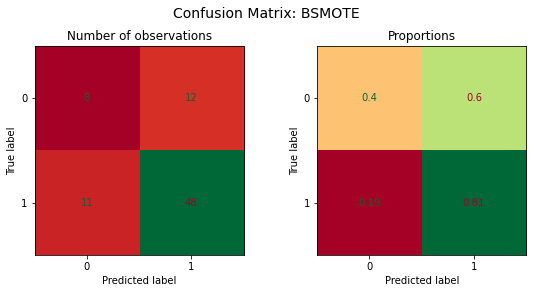

F1 Score (BSMOTE): 0.8067


In [43]:
# make predictions using optimal hyperparameters for resampling technique and model
bsmote = BorderlineSMOTE(sampling_strategy=0.8, k_neighbors=3, random_state=0)
X_bsmote, y_bsmote = bsmote.fit_resample(X_trainval, y_trainval)

robust_scaler = RobustScaler().fit(X_bsmote)
X_bsmote_transformed = robust_scaler.transform(X_bsmote)
X_holdout_transformed = robust_scaler.transform(X_holdout)

best_model = XGBClassifier(n_estimators=100, random_state=0) ######
best_model.fit(X_bsmote_transformed, y_bsmote)
y_pred = best_model.predict(X_holdout_transformed)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ConfusionMatrixDisplay.from_predictions(y_holdout, y_pred, ax=ax[0],
                                        cmap='RdYlGn', colorbar=False)
ax[0].set_title('Number of observations')
ConfusionMatrixDisplay.from_predictions(y_holdout, y_pred, ax=ax[1],
                                        cmap='RdYlGn', colorbar=False,
                                        normalize='true')
ax[1].set_title('Proportions')
fig.suptitle('Confusion Matrix: BSMOTE', fontsize=14)
fig.tight_layout()
plt.show()
print(f'F1 Score (BSMOTE): {f1_score(y_holdout, y_pred):.4f}')

## SHAP

[22:01:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


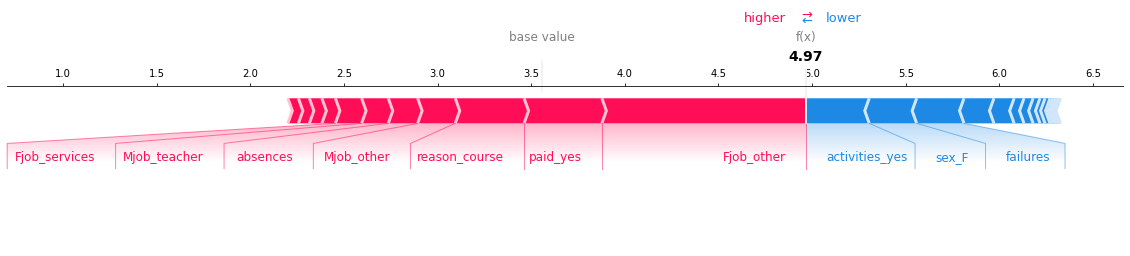

In [54]:
# instantiate model whose results will be interpreted
model = XGBClassifier(n_estimators=100, random_state=0)
model.fit(X_bsmote_transformed, y_bsmote)
y_pred = model.predict(X_holdout_transformed)

# use tree explainer to match XGBClassifier
explainer = shap.TreeExplainer(model, X_trainval)
shap_values = explainer.shap_values(X_holdout)

# generate force plot
shap.force_plot(explainer.expected_value, 
                shap_values[0], X.columns, matplotlib=True)

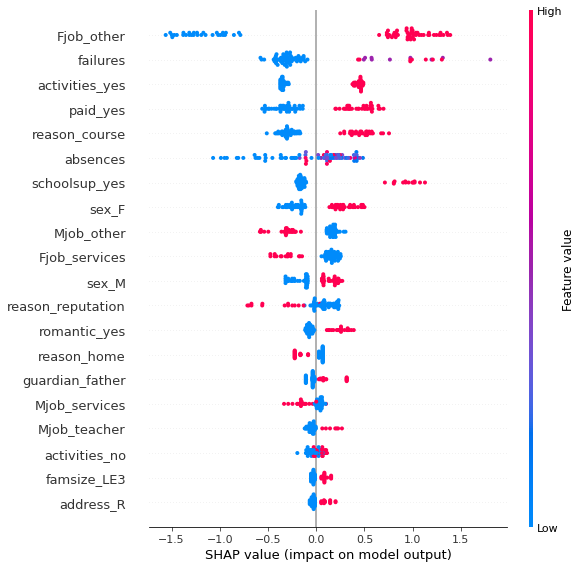

In [53]:
# generate summary plot
shap.summary_plot(shap_values=shap_values, features=X_holdout)

# Results and Discussion

As seen above, without applying resampling techniques we see that each model's predictions were biased towards the majority class, which is "fail". The model with the highest score was XGBoost, followed by GBM, then AdaBoost. However, these scores do not reflect the true performance of each model because majority of the predictions from each model were simply the majority class.

After resampling was done, we see that number of positive predictions (the majority class--"fail") decreased for GBM and XGBoost. The F1 scores of these models actually became lower, and for AdaBoost, the F1 score only increased slightly. However, this gives a more accurate measure of the models' performance because predictions are now less biased towards the majority class.

Using SHAP, different features can be highlighted depending on who the data is presented to. If presenting to the school admin, we can highlight useful insights such as the following: If the student has few failures, the prediction is pushed towards “pass”. If a student has few absences, it also pushes the prediction towards pass. These results were similar to that of the previous project. We also see that if the student’s reason for choosing the school is because of the course, the prediction is pushed towards “fail”. If the student’s reason was the school’s reputation, the prediction is pushed towards “pass”. If the reason was because it was close to home, the prediction is pushed towards “pass” as well.

If the parties concerned are the parents or guardians of the student, different insights can be highlighted: We can notice that the feature that most strongly pushes the prediction towards “fail” is when the father’s job is tagged “other”. In the survey, the choices for father’s job were teacher, health care related, civil services, at home or other. Therefore if the father’s job is not among those mentioned, the prediction is pushed towards "fail". If the students address is rural, it pushes the prediction towards “fail”. If a student does not have extra curricular activities, the prediction is pushed towards “pass”. If the guardian is the father, it pushes the prediciton towards "fail", and if the mothers job is a teacher, it also pushes the prediction towards "fail". Lastly, if the student is in a romantic relationship, the prediction is pushed towards "fail".

# Conclusion

Resampling techniques can decrease the bias in model results, and once Borderline SMOTE was performed, XGBoost and ADABoost performed better than GBM, with F1 scores of 80.99%, 80.67% and 78.69% respectively. Although the scores decreased after resampling, this still gives a more accurate picture of the models performance because bias towards the majority class has been removed. SHAP was also able to uncover that the feature that most strongly influences XGBoost's predictions of `fail` was if the father's job was not among teacher, health care related, civil services or at home. The feature that strongly pushes the prediction towards `pass` was if a student did not have any extra curricular activities.

# Acknowledgements
I would like to thank prof Chris Monterola, the ML 2 mentors, and my classmates for all their help in this project and my machine learning journey.

# References

https://towardsdatascience.com/class-imbalance-smote-borderline-smote-adasyn-6e36c78d804

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

https://medium.com/@cmukesh8688/sklearn-pipeline-gridsearchcv-54f5552bbf4e

https://christophm.github.io/interpretable-ml-book/shap.html

https://towardsdatascience.com/beginners-guide-to-xgboost-for-classification-problems-50f75aac5390

https://builtin.com/data-science/precision-and-recall